# Gamma-ray bursts prompt emission

- Dynamics:
    - Internal shock in a relativistic jet
- Emission (shock acceleration, synchrotron)

## Step 1: dynamics

In [19]:
from queue import PriorityQueue
import numpy as np
import matplotlib.pyplot as plt

speed_of_light = 1

class RelativisticShell:

    def __init__(self, rapidity, mass=1, initial_position=0, initial_time=0, lcoord=None):
        self.rapidity = rapidity
        self.gamma = np.cosh(rapidity)
        self.betagamma = np.sinh(rapidity)
        self.speed = speed_of_light * np.tanh(rapidity)
        self.mass = mass
        self.initial_position = initial_position
        self.initial_time = initial_time
        self.alive = True
        self.lcoord = lcoord
    
    def position(self, time):
        return self.initial_position + self.speed * (time - self.initial_time)
    
    def momentum(self):
        return self.mass * speed_of_light * self.gamma
    
    def kill(self):
        self.alive = False


class Emission:
    def __init__(self, time, energy, initial_position, shell_rapidity):
        self.time = time
        self.energy = energy 
        self.initial_position = initial_position
        self.shell_rapidity = shell_rapidity

        self.gamma = np.cosh(shell_rapidity)
        self.beta = np.tanh(shell_rapidity)
        self.doppler_shift = np.sqrt((1+self.beta)/(1-self.beta))
        self.arrival_time = time - initial_position / speed_of_light

    
class Event:
    def __init__(self, time, simulation):
        self.time = time
        self.simulation = simulation
    
    def process(self, verbose=True):
        pass

    def __lt__(self, other):
        return self.time < other.time

# Production of a shell
class RelativisticProduction(Event):
    def __init__(self, time, simulation, rapidity, mass=1, initial_position=0, lcoord=None):
        super().__init__(time, simulation)
        self.rapidity = rapidity
        self.mass = mass
        self.initial_position = initial_position
        self.lcoord = lcoord
    
    def process(self, verbose=True):
        shell = RelativisticShell(self.rapidity, self.mass, self.initial_position, self.time, lcoord=self.lcoord)
        self.simulation.time = self.time

        # find where to put this shell in the shell list
        done = False
        index = -1
        for i, s in enumerate(self.simulation.shells):
            if s.position(self.time) >= self.initial_position:
                self.simulation.shells.insert(i, shell)
                index = i
                done = True
                break
        if not done:
            index = len(self.simulation.shells)
            self.simulation.shells.append(shell)

        # compute new possible collisions with adjacent shells
        if  0 <= index-1:
            anterior = self.simulation.shells[index-1]
            self.simulation.predict_collision(self.time, anterior, shell)
        if index+1 < len(self.simulation.shells):
            posterior = self.simulation.shells[index+1]
            self.simulation.predict_collision(self.time, shell, posterior)


# Collision of two shells
class RelativisticCollision(Event):
    def __init__(self, time, simulation, s1, s2):
        super().__init__(time, simulation)
        self.s1 = s1
        self.s2 = s2

    def process(self, verbose=True):
        self.simulation.time = self.time

        s1, s2 = self.s1, self.s2

        # check if shells are still alive
        if not s1.alive or not s2.alive:
            return

        # check that positions are indeed equal
        tol = 1e-5
        assert abs(s1.position(self.time) - s2.position(self.time)) < tol
        
        # remove shells from list and kill them
        self.simulation.shells.remove(s1)
        self.simulation.shells.remove(s2)
        s1.kill()
        s2.kill()

        # compute parameters of new shell
        mass, rapidity, position, lcoord = self.simulation.compute_new_shell(self.time, s1, s2)
        if verbose:
            print(f"mass={mass}, rapidity={rapidity}, position={position}")

        # produce new shell
        e = RelativisticProduction(self.time, self.simulation, rapidity, mass, position, lcoord=lcoord)
        e.process(verbose=verbose)

        # compute emitted energy
        emitted_energy = self.simulation.compute_energy_emission(s1, s2, mass, rapidity)
        self.simulation.emissions.append(Emission(self.time, emitted_energy, position, rapidity))

        # register collision data
        # (time, position, mass1, mass2, mass, speed1, speed2, speed)
        data = (self.time, position, s1.mass, s2.mass, mass, s1.rapidity, s2.rapidity, rapidity)
        self.simulation.collisions.append(data)

########## Initial rapidity functions ###########
def rapidity_profile1(t, gamma_min=100, gamma_max=200, compression=8):
    return np.arccosh((gamma_max-gamma_min) * (1 / np.pi * np.arctan(compression*(t-0.5))+0.5) + gamma_min)

@np.vectorize
def rapidity_profile2(t, gamma_min=100, gamma_max=200):
    if t < 0.5: return np.arccosh(gamma_min)
    return np.arccosh(gamma_max)


########## Energy production functions ##########
def energy_profile1(t, rate=1):
    return rate   # constant energy

######## Emission profiles ########
@np.vectorize
def emission_profile1(t, boxsize=0.03, gamma=1):       # ad-hoc box profile
    if 0 <= t and t < gamma*boxsize:
        return 1
    return 0

class Simulation:
    def __init__(self, rapidity_profile, energy_profile, injection_time=5, injection_interval=0.001,
                rapidity_args={}, energy_args={}):
        self.shells = []                # list of shells in spatial order (leftmost shell at index 0)
        self.queue = PriorityQueue()    # queue of events (productions and collisions)
        self.emissions = []             # list of emissions represented by Emission objects
        self.collisions = []            # list of collisions (time, position, mass1, mass2, mass,
                                        # rapidity1, rapidity2, rapidity)

        self.rapidity_profile = rapidity_profile
        self.energy_profile = energy_profile
        self.rapidity_args = rapidity_args
        self.energy_args = energy_args

        self.injection_time = injection_time
        self.injection_interval = injection_interval
        self.injections = np.arange(0, injection_time, injection_interval)

        self.time = 0

        # Put production/injection events in queue
        self.injected_energy = 0
        for time in self.injections:
            rapidity = rapidity_profile(time/injection_time, **rapidity_args)
            energy_per_time = energy_profile(time/injection_time, **energy_args)
            mass = energy_per_time / np.cosh(rapidity) / speed_of_light**2 * injection_interval

            lcoord = [self.injected_energy]
            self.injected_energy += np.cosh(rapidity) * mass * speed_of_light**2
            lcoord.append(self.injected_energy)

            e = RelativisticProduction(time, self, rapidity, mass, lcoord=lcoord)
            self.queue.put(e)
    
    def run(self, amount=None, verbose=False):
        if amount is None:
            while not self.queue.empty():
                event = self.queue.get()
                event.process(verbose=verbose)
        
        else:
            for _ in range(amount):
                if self.queue.empty():
                    return
                event = self.queue.get()
                event.process(verbose=verbose)
    
    def generate_run(self, stop_every=100, verbose=False):
        while not self.queue.empty():
            self.run(amount=stop_every, verbose=verbose)
            yield self
    

    # collision of shell 1 and shell 2 gives shell with new parameters
    def compute_new_shell(self, now, s1, s2):
        
        mass = s1.mass + s2.mass
        beta = (s1.mass * s1.betagamma + s2.mass * s2.betagamma) / (s1.mass * s1.gamma + s2.mass * s2.gamma)
        rapidity = np.arctanh(beta)
        
        position = (s1.position(now) + s2.position(now)) / 2

        lcoord = [s2.lcoord[0], s1.lcoord[1]]

        return mass, rapidity, position, lcoord

    # energy lost in inelastic collision to be emitted
    def compute_energy_emission(self, s1, s2, mass, rapidity):

        energy_before = (s1.mass * s1.gamma + s2.mass * s2.gamma) * speed_of_light**2
        energy_after = mass * np.cosh(rapidity) * speed_of_light**2

        return energy_before - energy_after

    # this is pure kinematics in lab frame
    def predict_collision(self, now, s1, s2):
        if s1.rapidity > s2.rapidity:
            deltax = s2.position(now) - s1.position(now)
            deltav = s1.speed - s2.speed
            collision_time = now + deltax / deltav

            self.queue.put(RelativisticCollision(collision_time, self, s1, s2))
        
        
def plot_rapidity_initial(simu):
    t = np.linspace(0,1,101)
    plt.plot(t * simu.injection_time, simu.rapidity_profile(t, **simu.rapidity_args))
    plt.title("Rapidity profile")
    plt.xlabel("Time of shell production")
    plt.ylabel("Shell rapidity")
    plt.show()

def plot_gamma_initial(simu):
    t = np.linspace(0,1,301)
    plt.plot(t * simu.injection_time, np.cosh(simu.rapidity_profile(t, **simu.rapidity_args)))
    plt.title("Gamma profile")
    plt.xlabel("Time of shell production")
    plt.ylabel("Shell gamma factor")
    plt.show()
    
def plot_emissions(simu, emission_profile, maxtime=None, npoints=501, emission_args={}):
    t_init = simu.emissions[0].arrival_time
    if maxtime:
        t_end = t_init + maxtime
    else:
        t_end = simu.emissions[-1].arrival_time

    t = np.linspace(t_init, t_end, npoints)

    burst = sum([e.energy*emission_profile(t-e.arrival_time, gamma=e.gamma, **emission_args) for e in simu.emissions])

    plt.plot(t-t_init, burst)
    plt.title("Emitted energy per unit time")
    plt.xlabel("Arrival time")
    plt.ylabel("Emitted energy")
    plt.show()

def plot_collisions(simu):
    collisions = np.asarray(simu.collisions)
    time = collisions[:,0]
    position = collisions[:,1]
    plt.scatter(time, position, marker='.')
    plt.xlabel("Time")
    plt.ylabel("Position")
    plt.title("Locus of collisions")
    plt.yscale("log")
    plt.xscale("log")
    plt.show()

def test_energy_conservation(simu):
    energy_before = simu.injected_energy
    energy_after = sum(shell.mass * shell.gamma * speed_of_light**2 for shell in simu.shells) \
                + sum(e.energy for e in simu.emissions)
    return energy_before, energy_after, energy_before-energy_after

def lcoord2plottable(lcoords, quantities):
    res = []
    for lcoord, qtty in zip(lcoords, quantities):
        res.append((lcoord[1], qtty))
        res.append((lcoord[0], qtty))
    return np.asarray(res).T

def plot_gamma(simu):
    lcoords = [shell.lcoord for shell in simu.shells]
    gammas = [shell.gamma for shell in simu.shells]
    x, y = lcoord2plottable(lcoords, gammas)

    plt.plot(x, y)
    plt.xlabel("Lagrangian coordinate")
    plt.ylabel("Gamma factor")
    plt.title(f"Gamma factor distribution, t={simu.time}")
    plt.show()

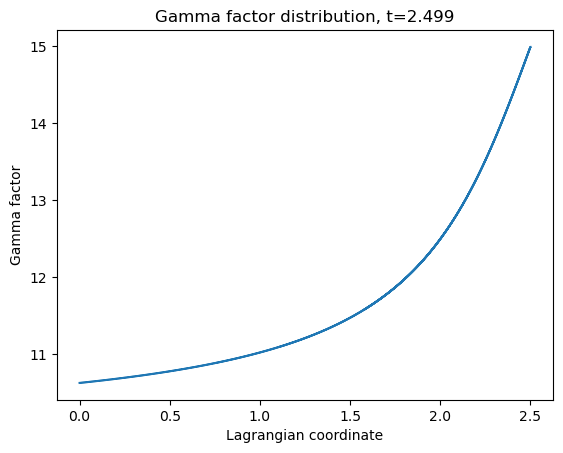

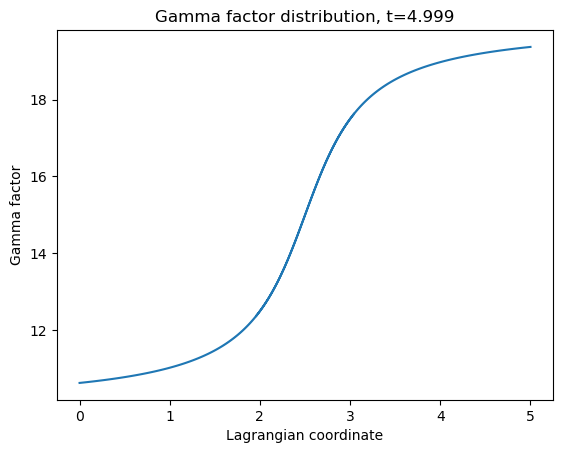

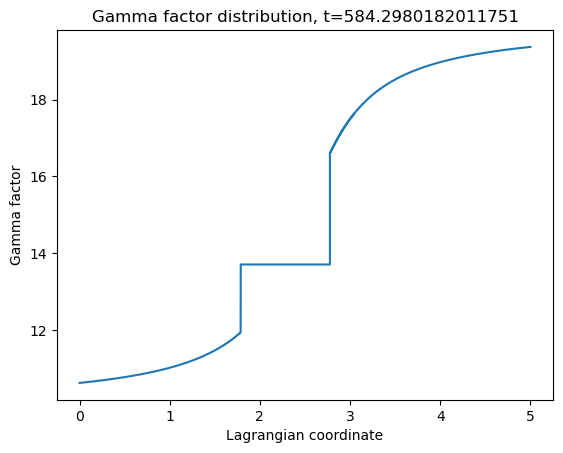

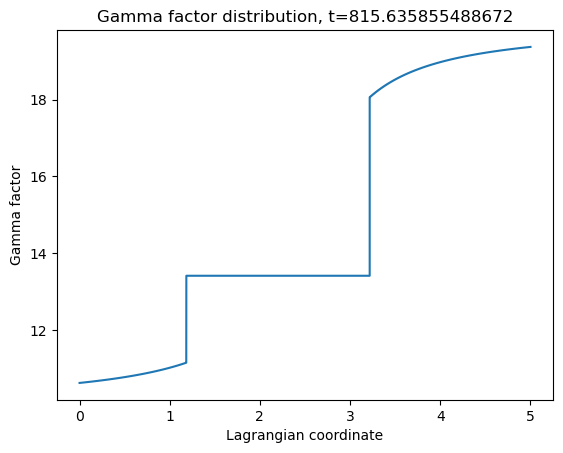

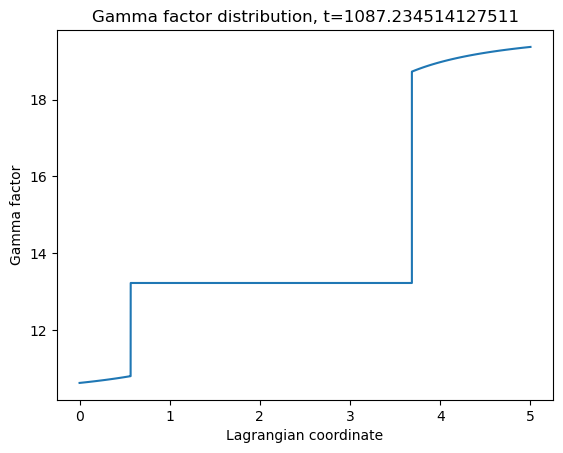

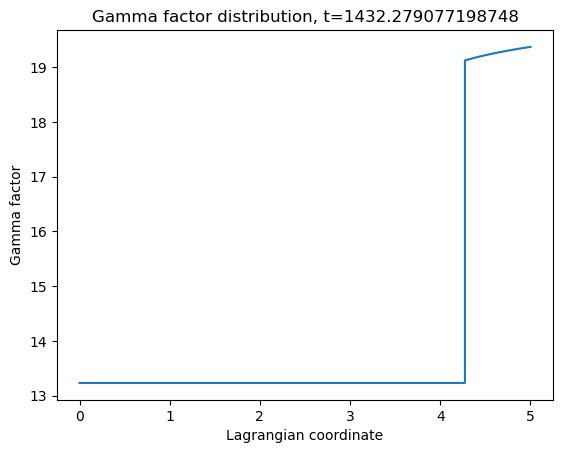

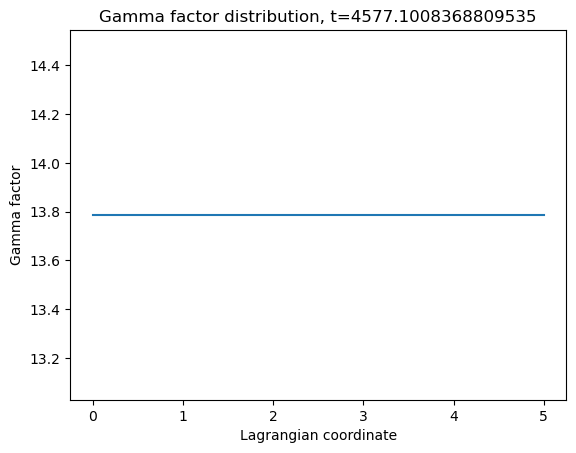

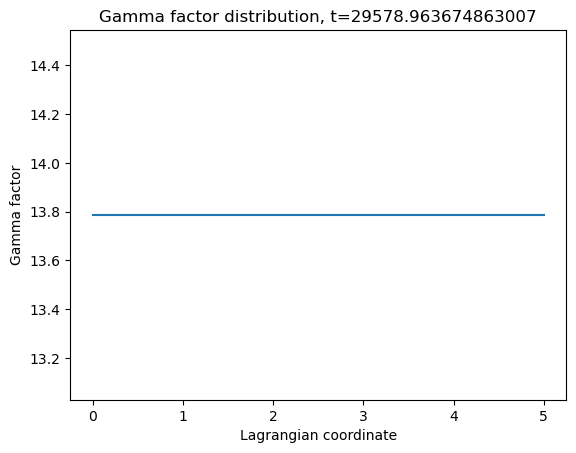

In [6]:
simu = Simulation(rapidity_profile1, energy_profile1,
                rapidity_args=dict(gamma_min=10, gamma_max=20, compression=10))

for snapshot in simu.generate_run(stop_every=2500):
    try:
        plot_gamma(snapshot)
    except:
        pass


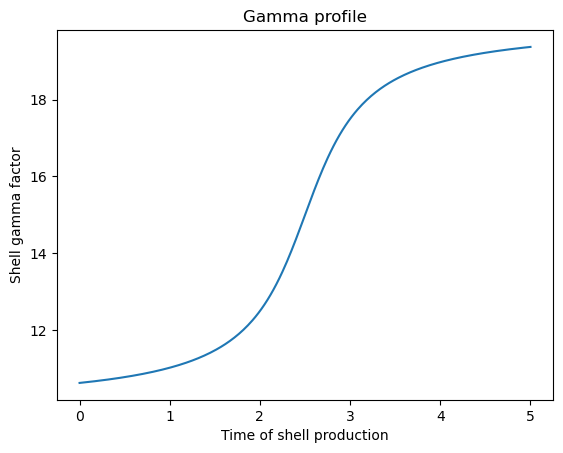

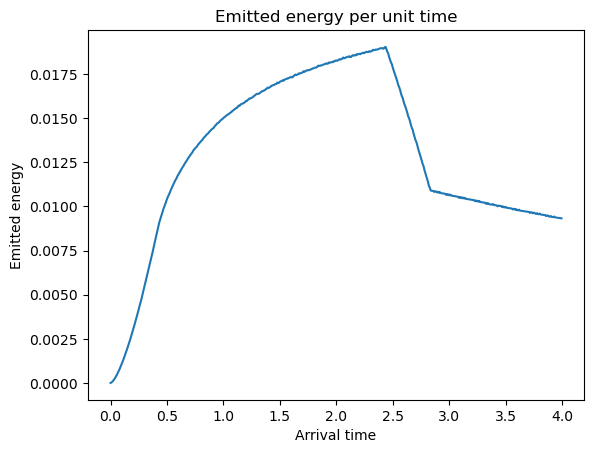

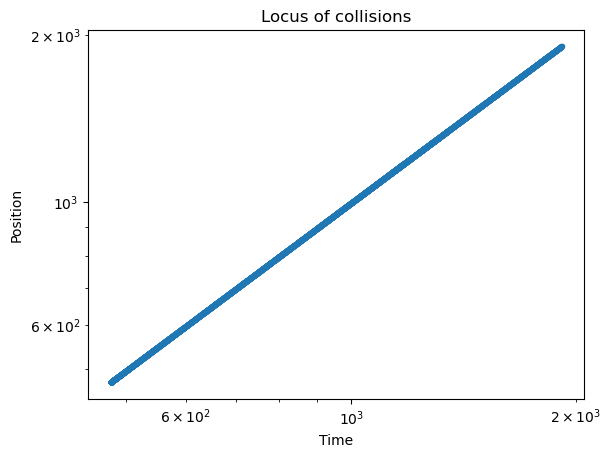

(5.000000000000004, 4.999999999999964, 4.085620730620576e-14)


In [20]:
plot_gamma_initial(simu)
plot_emissions(simu, emission_profile1)
plot_collisions(simu)
print(test_energy_conservation(simu))

## Step 2: properties of shocked matter

## Synchrotron emission

## Signal measured by the observer

## Discussion